# HW17

### Author: Joseph Wong

## Import the Packages

In [1]:
# Basic package imports
import os
import numpy as np
import pandas as pd

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: Core utilities for model building and evaluation
from sklearn.model_selection import train_test_split    # Train/test data splitting
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler  # Feature transformations and scaling
from sklearn.metrics import (                            # Model evaluation metrics
    mean_squared_error, r2_score, accuracy_score, 
    precision_score, recall_score, confusion_matrix, 
    classification_report
)

# Scikit-learn: Linear and polynomial models
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor       # For KNN

# Scikit-learn: Synthetic dataset generators
from sklearn.datasets import make_classification, make_regression

# Scikit-learn: Naive Bayes models
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

# Scikit-learn: Decision Trees
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

# Text Processing Packages and Code
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk.corpus import stopwords
from nltk import PorterStemmer as Stemmer

# Scikit-Learn: Datasets
from sklearn.datasets import fetch_california_housing, load_iris

## Part 1: Iris Data

### Import the Data

In [2]:
iris = load_iris()
X_cls, y_cls = iris.data, iris.target
feature_names_cls = iris.feature_names
class_names_cls = iris.target_names

df_iris = pd.DataFrame(X_cls,columns=feature_names_cls)
df_iris['Class Num'] = y_cls
print(class_names_cls)
df_iris

['setosa' 'versicolor' 'virginica']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Class Num
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


### Test Train Validate Split

In [3]:
x_cols = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
y_cols = ['Class Num']

X = df_iris[x_cols]
y = df_iris[y_cols]

# first split: hold out test data
seed = 16
X_train, X_test_full, y_train, y_test_full = train_test_split(X, y, test_size=0.2, random_state=seed)

# second split: create a validation set from the testing data
X_test, X_val, y_test, y_val = train_test_split(X_test_full, y_test_full, test_size=0.5, random_state=seed)

# final proportions are 80% train / 10% val / 10% test

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Train: 120, Validation: 15, Test: 15


### Normalize the Data

In [4]:
# define the scalar
scaler = StandardScaler()
# find mu and sigma of the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train)
# transform the validation data
X_val_scaled = scaler.transform(X_val)
# transform the test data
X_test_scaled = scaler.transform(X_test)

### Build the Model

In [5]:
tree = DecisionTreeClassifier(random_state=seed)
tree.fit(X_train_scaled, y_train)
y_pred_train = tree.predict(X_train_scaled)
y_pred_val = tree.predict(X_val_scaled)

print("Training Data Classification Report:")
print(classification_report(y_train, y_pred_train))
print("Validation Data Classification Report:")
print(classification_report(y_val, y_pred_val))

Training Data Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        38
           2       1.00      1.00      1.00        42

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

Validation Data Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.83      0.91         6
           2       0.80      1.00      0.89         4

    accuracy                           0.93        15
   macro avg       0.93      0.94      0.93        15
weighted avg       0.95      0.93      0.93        15



We will be looking at the macro average so that each class will be weighted equally (even though the data is mostly balanced). The training data has precision, recall, f1-score, and accuracy of 1.00, which suggests there may be some overfitting. The validation data has precision of 0.93, recall of 0.94, f1-score of 0.93, and accuracy of 0.93. These are all relatively large, which means the model is rather effective in its predictions.

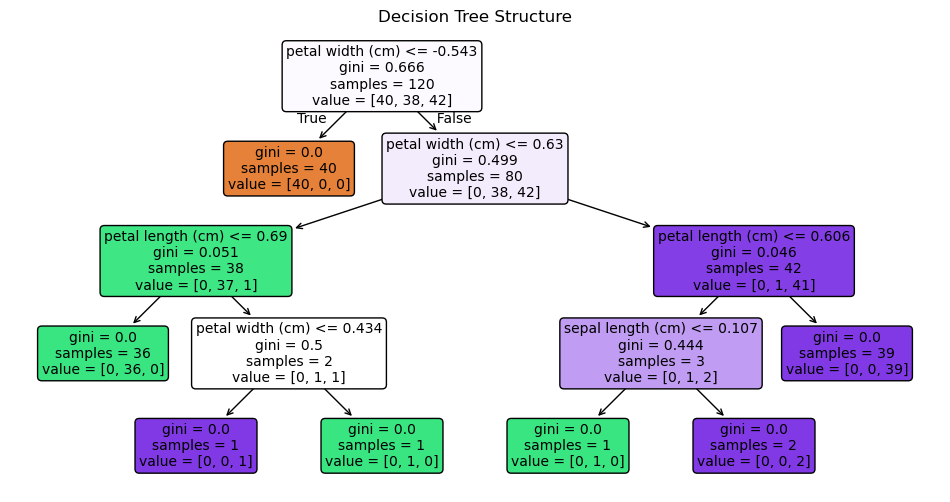

In [6]:
plt.figure(figsize=(12, 6))
plot_tree(tree,
          filled=True,
          feature_names=x_cols,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree Structure")
plt.show()

The decision tree structure tells us that the depth is 4 when we did not specify a max depth. So, the max depth that the model can produce is 4. At depth 2, the data appears to be almost completely classified correctly, except for two observations. Two splits are needed to properly classify these observations. This suggests the model may still be rather effective with a max depth of 2.

petal width (cm)     0.963723
petal length (cm)    0.019597
sepal length (cm)    0.016681
sepal width (cm)     0.000000
dtype: float64


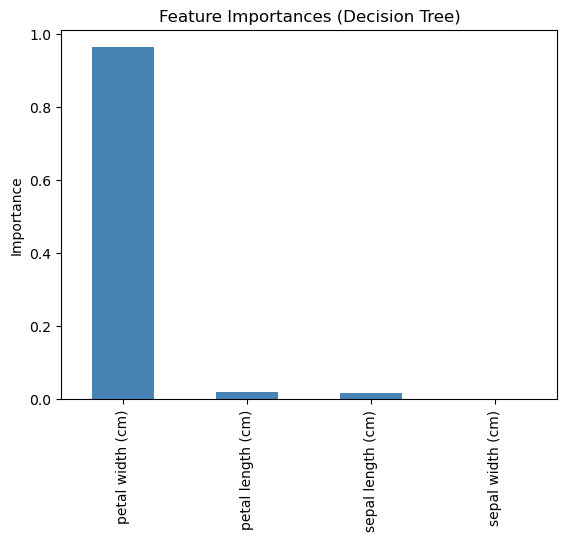

In [7]:
importances = pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

importances.plot(kind='bar', color='steelblue', title='Feature Importances (Decision Tree)')
plt.ylabel("Importance")
plt.show()

Petal width is the most important feature by a wide margin. Petal length and sepal length have slight impact on the prediction while sepal width was not used for predicting at all.

### Tune Tree Depth

In [8]:
for i in range(1,11):
    tree_tuner = DecisionTreeClassifier(random_state=seed, max_depth=i)
    tree_tuner.fit(X_train_scaled, y_train)
    y_pred_train = tree_tuner.predict(X_train_scaled)
    y_pred_val = tree_tuner.predict(X_val_scaled)

    # zero_division = 0 : if a certain class is not predicted, the score involving it is set to 0 (error was occuring with precision)
    print("Max Depth is " + str(i))
    print("Training Data Classification Report:")
    print(classification_report(y_train, y_pred_train, zero_division=0))
    print("Validation Data Classification Report:")
    print(classification_report(y_val, y_pred_val, zero_division=0))
    importances = pd.Series(tree_tuner.feature_importances_, index=X.columns).sort_values(ascending=False)
    print(importances)
    print()

Max Depth is 1
Training Data Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.00      0.00      0.00        38
           2       0.53      1.00      0.69        42

    accuracy                           0.68       120
   macro avg       0.51      0.67      0.56       120
weighted avg       0.52      0.68      0.57       120

Validation Data Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.00      0.00      0.00         6
           2       0.40      1.00      0.57         4

    accuracy                           0.60        15
   macro avg       0.47      0.67      0.52        15
weighted avg       0.44      0.60      0.49        15

petal width (cm)     1.0
sepal length (cm)    0.0
sepal width (cm)     0.0
petal length (cm)    0.0
dtype: float64

Max Depth is 2
Training Data Cl

It seems that as max depth increase, the precision, recall, f1-score, and accuracy increase. At a max depth of 1 and 2, only petal width is used by the model. As max depth increases, petal length and sepal length gain slight importance, which is taken from petal width's importance. After a max depth of 4, all values appear to plateau, which suggests the maximum depth the decision tree regressor can produce is 4. Although it has lower metric scores, we will use a max depth of 2 in our final model to avoid overfitting.

### Tune CCP Pruning

In [9]:
path = tree.cost_complexity_pruning_path(X_train_scaled, y_train)
for c in path.ccp_alphas:
    print(c)
    # these are the alphas that would change the tree structure

0.0
0.00811403508771929
0.00813492063492063
0.3000020885547202
0.333611111111111


Training Data Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.97      0.97      0.97        38
           2       0.98      0.98      0.98        42

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120

Validation Data Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.71      0.83      0.77         6
           2       0.67      0.50      0.57         4

    accuracy                           0.80        15
   macro avg       0.79      0.78      0.78        15
weighted avg       0.80      0.80      0.79        15

petal width (cm)     1.0
sepal length (cm)    0.0
sepal width (cm)     0.0
petal length (cm)    0.0
dtype: float64


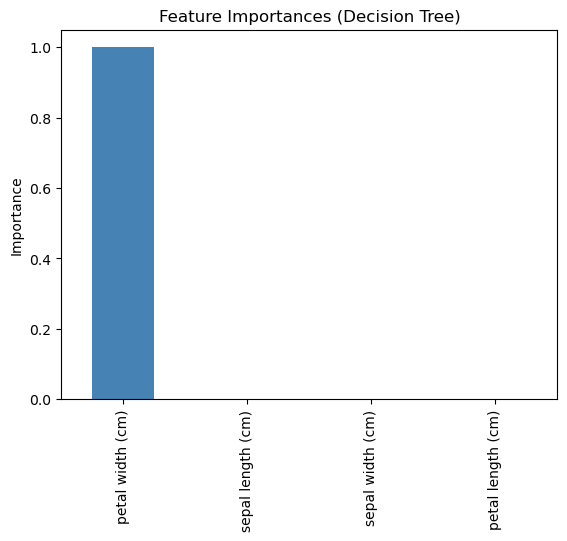

In [10]:
tree_tuner = DecisionTreeClassifier(random_state=seed, ccp_alpha=0.01)
tree_tuner.fit(X_train_scaled, y_train)
y_pred_train = tree_tuner.predict(X_train_scaled)
y_pred_val = tree_tuner.predict(X_val_scaled)

print("Training Data Classification Report:")
print(classification_report(y_train, y_pred_train))
print("Validation Data Classification Report:")
print(classification_report(y_val, y_pred_val))

# feature importance
importances = pd.Series(tree_tuner.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

importances.plot(kind='bar', color='steelblue', title='Feature Importances (Decision Tree)')
plt.ylabel("Importance")
plt.show()

We can see that adding pruning (alpha = 0.1) decreases the metric scores for both the training and validation data. The model built without pruning had more effective predictions, even though there is a potential for overfitting. To avoid overfitting and reduce model complexity, we will use an alpha of 0.01 that will prune some of the less important subtrees. Additionally, the only feature considered important by this model is petal width.

### Final Model

In [11]:
tree = DecisionTreeClassifier(random_state=seed, max_depth=2, ccp_alpha=0.01)
tree.fit(X_train_scaled, y_train)
y_pred_test = tree.predict(X_test_scaled)

print("Testing Data Classification Report:")
print(classification_report(y_test, y_pred_test))

Testing Data Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.86      1.00      0.92         6
           2       1.00      0.75      0.86         4

    accuracy                           0.93        15
   macro avg       0.95      0.92      0.93        15
weighted avg       0.94      0.93      0.93        15



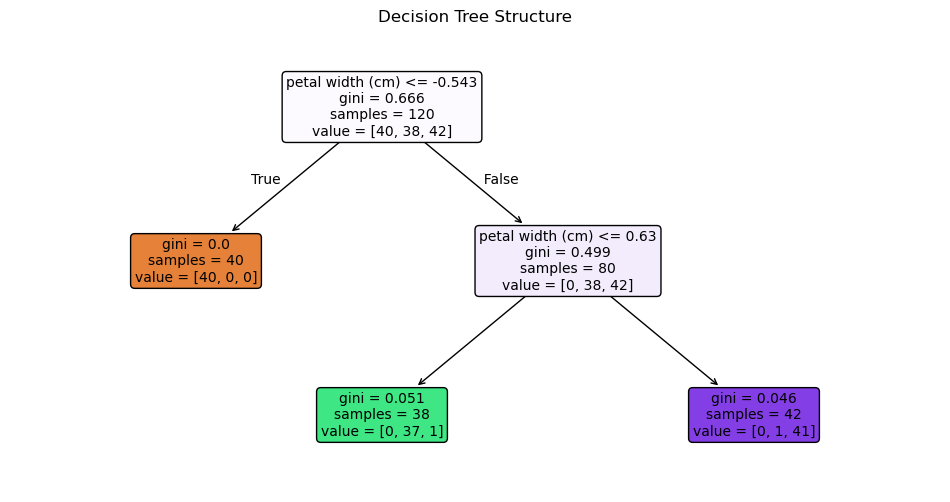

In [12]:
plt.figure(figsize=(12, 6))
plot_tree(tree,
          filled=True,
          feature_names=x_cols,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree Structure")
plt.show()

This final model is fairly effective in classifying the flower class, as it has an accuracy of 0.93. Precision, recall, and f1-score are all rather high as well, being 0.95, 0.92, and 0.93 respectively. As we can see in the decision tree structure, the model is not too complex while still maintaining accurate predictions.

## Part 2: California Housing Data

### Import the Data

In [13]:
housing = fetch_california_housing()
X_reg, y_reg = housing.data, housing.target
feature_names_reg = housing.feature_names

df_housing = pd.DataFrame(X_reg,columns=feature_names_reg)
df_housing['Price'] = y_reg
df_housing

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


### Test Train Validate Split

In [14]:
df_housing.keys()

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'Price'],
      dtype='object')

In [15]:
x_cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
y_cols = ['Price']

X = df_housing[x_cols]
y = df_housing[y_cols]

# first split: hold out test data
seed = 16
X_train, X_test_full, y_train, y_test_full = train_test_split(X, y, test_size=0.2, random_state=seed)

# second split: create a validation set from the testing data
X_test, X_val, y_test, y_val = train_test_split(X_test_full, y_test_full, test_size=0.5, random_state=seed)

# final proportions are 80% train / 10% val / 10% test

print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Train: 16512, Validation: 2064, Test: 2064


### Normalize the Data

In [16]:
# define the scalar
scaler = StandardScaler()
# find mu and sigma of the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train)
# transform the validation data
X_val_scaled = scaler.transform(X_val)
# transform the test data
X_test_scaled = scaler.transform(X_test)

### Build the Model

In [17]:
tree = DecisionTreeRegressor(random_state=seed)
tree.fit(X_train_scaled, y_train)
y_pred_train = tree.predict(X_train_scaled)
y_pred_val = tree.predict(X_val_scaled)

mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print("Training Data:")
print(f"MSE: {mse_train:.3f}")
print(f"R²: {r2_train:.3f}")
print()
print("Validation Data Classification Report:")
print(f"MSE: {mse_val:.3f}")
print(f"R²: {r2_val:.3f}")

Training Data:
MSE: 0.000
R²: 1.000

Validation Data Classification Report:
MSE: 0.476
R²: 0.644


The training set has a mse of 0 and R² of 1, which suggests there is overfitting happening. The validation set has a mse of 0.476 and R² of 0.644, which is not amazing. Hopefully tuning this model through pruning will remove the potential overfitting and improve our model's success with unseen data. We cannot even graph the decision tree structure or feature importance because there are too many branches.

### Tune Tree Depth

In [18]:
for i in range(5,16):
    tree_tuner = DecisionTreeRegressor(random_state=seed, max_depth=i)
    tree_tuner.fit(X_train_scaled, y_train)
    y_pred_train = tree_tuner.predict(X_train_scaled)
    y_pred_val = tree_tuner.predict(X_val_scaled)

    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    mse_val = mean_squared_error(y_val, y_pred_val)
    r2_val = r2_score(y_val, y_pred_val)

    # zero_division = 0 : if a certain class is not predicted, the score involving it is set to 0 (error was occuring with precision)
    print("Max Depth is " + str(i))
    print("Training Data:")
    print(f"MSE: {mse_train:.3f}")
    print(f"R²: {r2_train:.3f}")
    print("Validation Data:")
    print(f"MSE: {mse_val:.3f}")
    print(f"R²: {r2_val:.3f}")
    # feature importance
    importances = pd.Series(tree_tuner.feature_importances_, index=X.columns).sort_values(ascending=False)
    print(importances)
    print()

Max Depth is 5
Training Data:
MSE: 0.485
R²: 0.636
Validation Data:
MSE: 0.476
R²: 0.644
MedInc        0.740204
AveOccup      0.152318
HouseAge      0.044924
Longitude     0.032513
Latitude      0.027056
Population    0.002985
AveBedrms     0.000000
AveRooms      0.000000
dtype: float64

Max Depth is 6
Training Data:
MSE: 0.422
R²: 0.683
Validation Data:
MSE: 0.419
R²: 0.687
MedInc        0.694702
AveOccup      0.150416
Latitude      0.052576
HouseAge      0.048840
Longitude     0.044081
AveRooms      0.003476
AveBedrms     0.003130
Population    0.002779
dtype: float64

Max Depth is 7
Training Data:
MSE: 0.367
R²: 0.724
Validation Data:
MSE: 0.394
R²: 0.705
MedInc        0.661310
AveOccup      0.150265
Latitude      0.066322
Longitude     0.061640
HouseAge      0.047770
AveBedrms     0.006094
AveRooms      0.003870
Population    0.002729
dtype: float64

Max Depth is 8
Training Data:
MSE: 0.310
R²: 0.767
Validation Data:
MSE: 0.362
R²: 0.730
MedInc        0.628375
AveOccup      0.14481

It seems that a max depth of 9 maximizes R² for the validation data (0.736) and produces a decently high R² for the training set (0.806). Also, the mean squared errors do not seem too large. At a max depth of 5, MedInc is the most important feature. As the max depth increases, MedInc's importance gets spread spread among the other features, whose importances tend to increase. It seems at a max depth of 9, MedInc is still the most important feature, but the others are still considered. Although it is slightly more complex than I would prefer, models with less feature complexity have lower metric scores. So, we will prioritize the scores over complexity. We will use a max depth of 9 in our final model. 

### Tune CCP Pruning

In [19]:
path = tree.cost_complexity_pruning_path(X_train_scaled, y_train)
for c in path.ccp_alphas:
    print(c)
    # these are the alphas that would change the tree structure

0.0
4.034240641806528e-20
5.378987522408704e-20
5.378987522408704e-20
5.378987522408704e-20
5.378987522408704e-20
5.378987522408704e-20
8.068481283613056e-20
8.068481283613056e-20
1.0757975044817408e-19
1.0757975044817408e-19
1.0757975044817408e-19
1.0757975044817408e-19
1.0757975044817408e-19
1.6136962567226112e-19
1.6136962567226112e-19
2.1515950089634816e-19
2.1515950089634816e-19
4.3031900179269633e-19
4.3031900179269633e-19
4.3031900179269633e-19
4.3031900179269633e-19
4.3031900179269633e-19
4.3031900179269633e-19
7.171983363211605e-19
8.606380035853927e-19
8.606380035853927e-19
8.606380035853927e-19
1.219237171745973e-18
1.219237171745973e-18
1.290957005378089e-18
1.6136962567226112e-18
1.6136962567226112e-18
1.7212760071707853e-18
1.8288557576189596e-18
2.581914010756178e-18
1.2479251051988194e-17
3.0982968129074136e-17
3.8298391159549974e-17
4.5183495188233115e-17
5.341334609751843e-17
5.378987522408704e-17
1.0973134545713766e-16
2.521454191004304e-15
3.0279396561143076e-15
3.0

Training Data:
MSE: 0.279
R²: 0.791
Validation Data:
MSE: 0.355
R²: 0.735
MedInc        0.608292
AveOccup      0.146108
Longitude     0.086405
Latitude      0.085327
HouseAge      0.045496
AveBedrms     0.010780
AveRooms      0.009447
Population    0.008145
dtype: float64


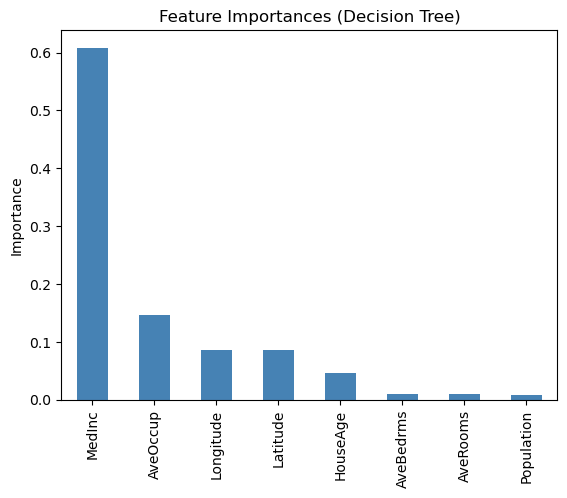

In [20]:
tree_tuner = DecisionTreeRegressor(random_state=seed, ccp_alpha=0.0005)
tree_tuner.fit(X_train_scaled, y_train)
y_pred_train = tree_tuner.predict(X_train_scaled)
y_pred_val = tree_tuner.predict(X_val_scaled)

mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print("Training Data:")
print(f"MSE: {mse_train:.3f}")
print(f"R²: {r2_train:.3f}")
print("Validation Data:")
print(f"MSE: {mse_val:.3f}")
print(f"R²: {r2_val:.3f}")

# feature importance
importances = pd.Series(tree_tuner.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

importances.plot(kind='bar', color='steelblue', title='Feature Importances (Decision Tree)')
plt.ylabel("Importance")
plt.show()

There are a lot of paths in this model! Through trial and error, it seems that pruning with an alpha of 0.0005 balances avoiding potential overfitting while maintaining a realtively high R² (0.791 training, 0.735 validation). MedInc is still the most important feature. We will use an alpha of 0.0005 in our final model.

### Final Model

In [21]:
tree = DecisionTreeRegressor(random_state=seed, max_depth=9, ccp_alpha=0.0005)
tree.fit(X_train_scaled, y_train)
y_pred_test = tree.predict(X_test_scaled)

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Testing Data:")
print(f"MSE: {mse_test:.3f}")
print(f"R²: {r2_test:.3f}")

Testing Data:
MSE: 0.381
R²: 0.712


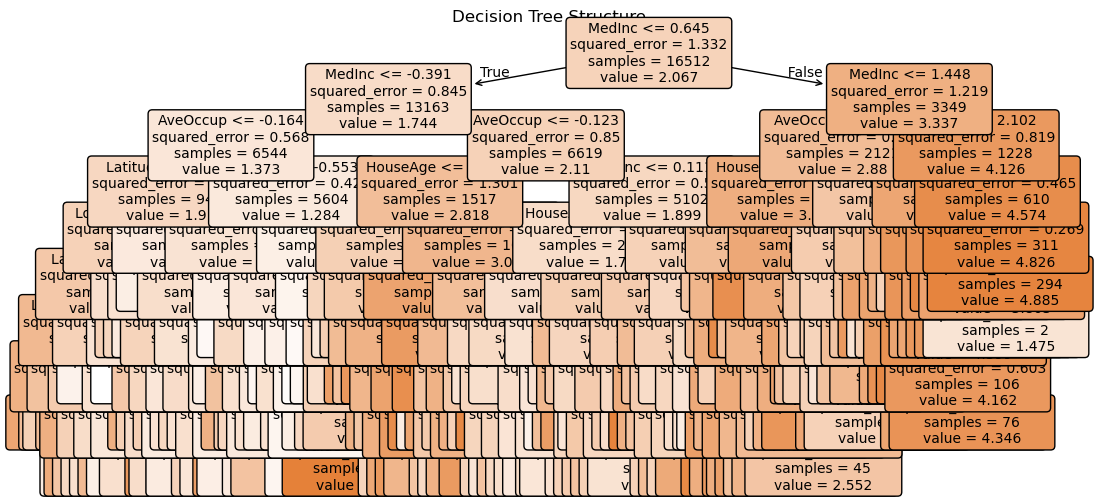

In [22]:
plt.figure(figsize=(12, 6))
plot_tree(tree,
          filled=True,
          feature_names=x_cols,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree Structure")
plt.show()

The final model can somewhat effectively predict price but it is not amazing. It has an R² of 0.712 and a mean squared error of 0.381 which is decent. When considering the decision tree structure, the model is still rather complex. However, I wasn't able to lessen the complexity without significantly reducing the model's predictive ability.